In [200]:
import numpy as np
import matplotlib.pyplot as plt
import os
import fnmatch
%matplotlib notebook
%matplotlib notebook

from latexify import latexify
latexify()

from lmfit import minimize, Model, Minimizer, Parameters, Parameter, report_fit
from scipy.signal import savgol_filter

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from scipy import interpolate

#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return np.vstack([meanx,meany,std_y]).T #putput: nbins rows, 3 col

In [221]:
print(2.3e6/(851e6*0.2)**2, 2e6/2/(851.6e6*0.2)**2) #in s: tau = lam[s]/(gamma[rad T-1] * B[Tesla])^2 for TbSnO PRL paper
print(2*(851.6e6*0.1)**2 / (300.*2.083e10) / 1e6) # lam[\muS^-1] = 2(gamma[radT^-1]*delta[Tesla])^2 / (T[K]*2e10) / 1e6
print(2*(135e6*0.2)**2/(300.*2.083e10)/1e6)
print(2e6/2/(135e6*0.2)**2) 
x = 1/(2e6/2/(135.6e6*0.2)**2)
x = 1/(2e6/2/(851.6e6*0.2)**2)
print("{:1.2e}".format(x), '%1.2e'%(x))

7.93978467304e-11 3.44721763758e-11
0.00232108356537
0.000233317330773
1.37174211248e-09
2.90e+10 2.90e+10


In [3]:
4*3.14*np.sin(70/180*3.14)/2.4
np.array([130,156,168,183])-20

array([110, 136, 148, 163])

In [3]:
# save only one subplot
# http://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    #items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

<IPython.core.display.Javascript object>


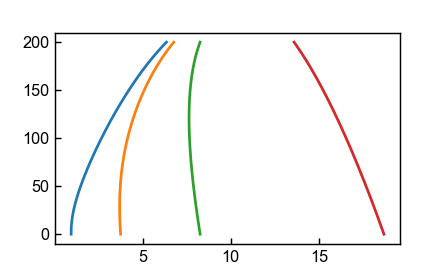

<IPython.core.display.Javascript object>


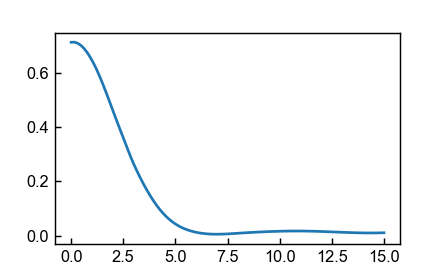

<IPython.core.display.Javascript object>


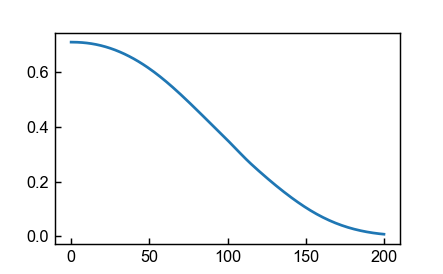

In [7]:
def loaddat(fpath,fname,kwargs):
    f = os.path.join(fpath, fname);
    print(f)
    dat = np.genfromtxt(f,**kwargs) # kwargs is a dictionary and use'**' to convert to kwargs
    return dat[~np.isnan(dat[:,1]),:] 

def fitReg(dat, *args):
    if len(args)==1:# when the low and high limits is in a list
        mask = (args[0][0]< dat[:,0]) & (dat[:,0] < args[0][1])
    else: # two augs give the the two limits
        mask = (args[0]< dat[:,0]) & (dat[:,0] < args[1])
    return dat[mask,:]

def streExp(x,a,lam,c,beta,cons):
    return a*np.exp(-(lam*x-c)**beta)+ cons


# Ｃａｌｃｕｌａｔｅｄ　ｔｈｅ　ｃｏｒｒｅｓｐｉｎｄｉｎｇ　Ｑ　ｆｏｒ　ｔｈｅ　２ｔｈｅａｔａ　ｃｕｔ
mn = 1.675e-27 # neutron mass in Kg
hbar = 1.0546e-34 # in J s
coeffi0 = hbar**2/(2*mn) # in J m2
coeffi = hbar**2 / (2*mn) * 6.24181 * 10**21 * 10**20 # in meV A2

def clcq(ei, e, th2):
    f = ei - e; i = ei
    q = ((f + i - 2 * (f*i)**0.5 * np.cos(np.pi/180*th2))/coeffi)**0.5
    return q

es = np.linspace(0,200,400)
plt.figure()
plt.plot(clcq(241.45,es,5),es)
plt.plot(clcq(241.45,es,20),es)
plt.plot(clcq(241.45,es,45),es)
plt.plot(clcq(241.45,es,120),es)
plt.show()

#　Load Sm3+ form facotor for intermultiplet transitions (k/4pi vs I)
smform = np.genfromtxt(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\Sm_formfactor_intermultiplet_transition.txt',skip_header=1)
smform[:,0]=smform[:,0]*4*np.pi
# make a interplation function
spl = interpolate.UnivariateSpline(smform[:,0], smform[:,1], s = 0.0001) # larger s more smooth
qs = np.linspace(0,15,num=100)
plt.figure()
plt.plot(qs,spl(qs))
plt.show()

from scipy import integrate
def ff_int(deltaE, two_th_low, two_th_high, ei=241.45):
    deltaE= np.asarray(deltaE)
    q_low, q_high = clcq(ei, deltaE, two_th_low), clcq(ei, deltaE, two_th_high)
    q_w = q_high - q_low
    #print(np.vstack([q_low,q_high]).T)
    if two_th_low!=two_th_high:
        if len(deltaE)>1:
            #print('good')
            return np.array([integrate.quad(spl, q_l, q_h)[0] for q_l, q_h in zip(q_low,q_high)])\
                   /q_w
        else: 
            return integrate.quad(spl, q_l, q_h)
    else:
        #print('good2')
        return spl(q_low)
    
plt.figure()
es = np.linspace(0,200,num=201)
plt.plot(es, ff_int(es,1,2))
plt.show()    

## Subtract background: 
1. La$_2$Hf$_2$O$_7$, 
2. Sm$_2$Hf$_2$O$_7$ high angle

## Sm-a*La-b subtraction for 2theta=7.5deg
1. Load data
2. Check subtraction
3. Fit subtracted data with PV without formfactor (the fit with ff is shown in the 20deg data)

In [9]:
fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/'
fnames=['MER31902_Ei235.00meV_Rings_cut(5,10).txt',
        'MER31930_Ei235.00meV_Rings_cut(5,10).txt',
        'MER31902_Ei235.00meV_Rings_cut(6,10).txt',
        'MER31930_Ei235.00meV_Rings_cut(6,10).txt',
       ]
two_th = np.array([[5,10],[5,10],[6,10],[6,10]])
loadpar = dict(skip_header=1, usecols=(0,1,2))

D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31902_Ei235.00meV_Rings_cut(6,10).txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31930_Ei235.00meV_Rings_cut(6,10).txt


<IPython.core.display.Javascript object>


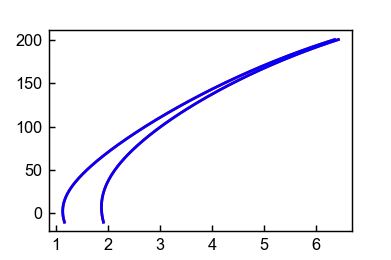

<IPython.core.display.Javascript object>


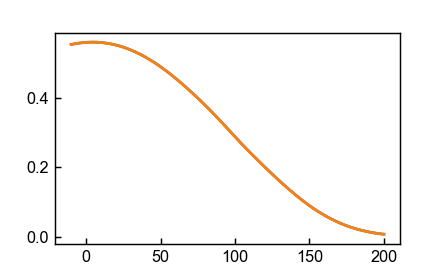

In [11]:
# ｌｏａｄ　ｄａｔａ：　ｌｏｗ　ａｎｇｌｅ　ａｎｄ　ａｌｓｏ　ｈｉｇｈ　ａｎｇｌｅ
wch = [2,3]
d_large = loaddat(fpath,fnames[wch[0]],loadpar) # low angle 6deg data of La,Sm2Zr2O7
d_small = loaddat(fpath,fnames[wch[1]],loadpar) # high angle 119deg data of Sm2Zr2O7

# low and high q limits for different energy within certain 2theta range
qs0 = np.vstack([clcq(241.45, d_large[:,0], two_th[wch[0],0]), 
                 clcq(241.45, d_large[:,0], two_th[wch[0],1])]).T
qs1 = np.vstack([clcq(241.45, d_small[:,0], two_th[wch[1],0]), 
                 clcq(241.45, d_small[:,0], two_th[wch[1],1])]).T
plt.figure(figsize=(3,2))
plt.plot(qs0,d_large[:,0],'r')
plt.plot(qs1,d_large[:,0],'b')
plt.show()

ff_int0 = np.array([integrate.quad(spl, qs_lh[0], qs_lh[1])[0]/(qs_lh[1]-qs_lh[0]) for qs_lh in qs0])
ff_int1 = np.array([integrate.quad(spl, qs_lh[0], qs_lh[1])[0]/(qs_lh[1]-qs_lh[0]) for qs_lh in qs1])
#print(ff_int0,'\n',ff_int1)

plt.figure()
plt.plot(d_large[:,0],ff_int0)
plt.plot(d_small[:,0],ff_int1)

plt.show()


('La$_2$T$_2$O$_7$', 'Sm$_2$T$_2$O$_7$', 'Subtraction')


<IPython.core.display.Javascript object>


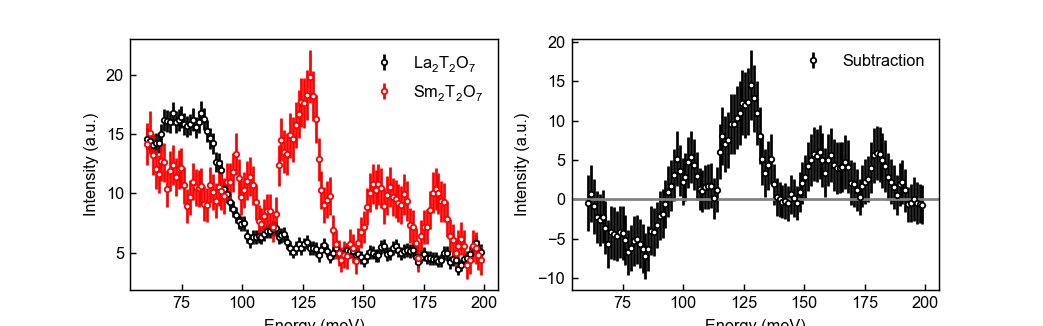

interactive(children=(FloatSlider(value=0.5, description='x1', max=2.0, step=0.01), FloatSlider(value=0.0, des…

<function __main__.pltSub(x1=0, x2=0)>

In [12]:
#　Check　Sm(2t:5-45)- a*Sm(2t:25-45)-b subtraction and plot
fig_label = (r'La$_2$T$_2$O$_7$', r'Sm$_2$T$_2$O$_7$','Subtraction')
print(fig_label)

factor, const = 1,0

def pltSub(x1=0,x2=0):
    global fig, axs, factor, const
    axs[0].cla() 
    
    mask = (60< d_small[:,0]) & (d_small[:,0] <200)
    
    axs[0].errorbar(d_small[mask,0], x1*d_small[mask,1]+x2, yerr=x1*d_small[mask,2],ms=3,
                    mec='black', mfc='white',fmt='o',ecolor='black',label=fig_label[0])# plot a*La+b
    axs[0].errorbar(d_large[mask,0], d_large[mask,1], yerr= d_large[mask,2], ms=3,
                    mec='r', mfc='white',fmt='o',ecolor='r',label=fig_label[1])# plot Sm
    axs[0].legend(loc='best',numpoints=1,frameon=False)
    #axs[0].text(145,6,r'$2\theta=[8,10]$ deg',fontsize=14)
    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')#, zorder=0)#,xmin=80,xmax=220,)#,linewidth=0.5)
    axs[1].errorbar(d_large[mask,0], d_large[mask,1]-x1*d_small[mask,1]-x2, yerr=2*d_large[mask,2],ms=3.,
                    fmt='o', mec='black', mfc='white',ecolor='black', label=fig_label[2])
    axs[1].legend(loc='best',numpoints=1,frameon=False)
    
    
    #ax.set_yscale('log')
    axs[0].set_xlabel('Energy (meV)')
    axs[0].set_ylabel('Intensity (a.u.)')
    axs[1].set_xlabel('Energy (meV)')
    axs[1].set_ylabel('Intensity (a.u.)')

    factor=x1; const=x2
    return #fig

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(8,2.5))

interact(pltSub, x1=widgets.FloatSlider(min=0,max=2,step=0.01,value=0.5),
         x2=widgets.FloatSlider(min=-10,max=15,step=0.5,value=0))

0.5 0.0
[[Model]]
    Model(five_pv)
[[Fit Statistics]]
    # function evals   = 382
    # data points      = 68
    # variables        = 15
    chi-square         = 63378.384
    reduced chi-square = 1195.819
    Akaike info crit   = 494.941
    Bayesian info crit = 528.234
[[Variables]]
    A0:        521.707805 +/- 263.7919 (50.56%) (init= 1000)
    ratio0:    0.12286960 +/- 1.211724 (986.19%) (init= 0.5)
    mu0:       119 (fixed)
    sigma0:    3.09714821 +/- 0.569365 (18.38%)  == 'gamma0/(2*log2(2))**0.5'
    gamma0:    4.38002901 +/- 0.805204 (18.38%) (init= 5)
    A1:        1206.13653 +/- 801.0165 (66.41%) (init= 1000)
    ratio1:    0.12286960 +/- 1.211724 (986.19%)  == 'ratio0'
    mu1:       128.233840 +/- 0.796133 (0.62%) (init= 128)
    sigma1:    3.09714821 +/- 0        (0.00%)  == 'sigma0'
    gamma1:    4.38002901 +/- 0.805204 (18.38%)  == 'gamma0'
    A2:        936.402341 +/- 578.0498 (61.73%) (init= 1000)
    ratio2:    1.4656e-08 +/- 0.501750 (3423611379.60%) (init

<IPython.core.display.Javascript object>


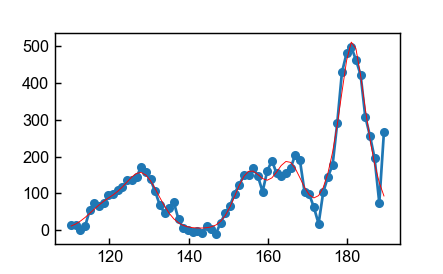

In [19]:
# Fit peak position and intensity based on the subtractd data
# with PV function ｗｉｔｈｏｕｔ　ｃｏｎｓｉｄｅｒｉｎｇ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
# a cell below do the fitting ｗｉｔｈ　ｃｏｎｓｉｄｅｒｉｎｇ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
def pv_func(x,A,ratio,mu,sigma,gamma):
    return A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
              ratio/np.pi*gamma/((x-mu)**2+gamma**2))
    
def five_pv(x,A0,ratio0,mu0,sigma0,gamma0,
            A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A0,ratio0,mu0,sigma0,gamma0) + \
           pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3)

print(factor,const)

## No formfactor correction
#d_sub = np.vstack([d_large[:,0], d_large[:,1]-factor*d_small[:,1]-const, d_large[:,2]]).T

## Do the formfactor correction: "/(ff_int0)"
# d_sub = np.vstack([d_large[:,0], 
#                    (d_large[:,1]-factor*d_small[:,1]-const)/(ff_int0), 
#                    d_large[:,2]]).T

## Do the formfactor correction: "/(ff_int0- factor*ff_int0)"
d_sub = np.vstack([d_large[:,0], 
                   (d_large[:,1]-factor*d_small[:,1]-const)/(ff_int0- factor*ff_int1), 
                   d_large[:,2]]).T

mask = (110< d_sub[:,0]) & (d_sub[:,0] <190)
d_sub = d_sub[mask,:]

pvmod=Model(five_pv)

params = pvmod.make_params()

# the phonon peak at 120meV
params['A0'].set(value=1000., vary=True, min=0, max=None)
params['ratio0'].set(value=0.5, vary=True, min=0, max=1)
params['mu0'].set(value=119, vary=False, min=None, max=None)
params['sigma0'].set(value=None, vary=False, min=None, max=None, expr='gamma0/(2*log2(2))**0.5')
params['gamma0'].set(value=5, vary=True, min=None, max=None)

# Four magnetic peaks
params['A1'].set(value=1000., vary=True, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1,expr='ratio0')
params['mu1'].set(value=128, vary=True, min=123, max=132)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='sigma0') # constrant
params['gamma1'].set(value=5, vary=True, min=None, max=None,expr='gamma0')

params['A2'].set(value=1000, vary=True, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=160., vary=True, min=150, max=170)
params['sigma2'].set(value=None, vary=False, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=5, vary=True, min=None, max=None)

# fit with four pv_functions and constrian the overlapping peak to have the same width
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=1000, vary=True, min=0, max=None)
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=170., vary=True, min=160, max=180)
params['sigma20'].set(value=None, vary=False, min=None, max=None, expr='sigma2') # constrant
params['gamma20'].set(value=None, vary=False, min=0, max=None,expr='gamma2')

params['A3'].set(value=5000, vary=True, min=0, max=None)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=180, vary=True, min=175, max=185)
params['sigma3'].set(value=None, vary=False, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=3, vary=True, min=0, max=4)

#print params.valuesdict()

result = pvmod.fit(d_sub[:,1], x=d_sub[:,0], params = params)
print(result.fit_report(modelpars=None, show_correl=False))
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots()
ax.errorbar(d_sub[:,0], d_sub[:,1], d_sub[:,2],marker='o', ms=4)
ax.plot(d_sub[:,0], result.best_fit, 'r-', lw=0.5, alpha=1, label=fig_label[1],zorder=10) 
#ax.set_ylim([-2,8])
plt.show()


In [25]:
params.keys()

odict_keys(['A0', 'ratio0', 'mu0', 'sigma0', 'gamma0', 'A1', 'ratio1', 'mu1', 'sigma1', 'gamma1', 'A2', 'ratio2', 'mu2', 'sigma2', 'gamma2', 'A20', 'ratio20', 'mu20', 'sigma20', 'gamma20', 'A3', 'ratio3', 'mu3', 'sigma3', 'gamma3'])

In [75]:
import uncertainties as unc  
import uncertainties.unumpy as unp  

## Calculate ratio with errorbars
# use list comprehensive
popt = np.array([unc.ufloat(result.best_values[key],result.params[key].stderr)
                 if 'A' in key else np.nan for key in params.keys()])
perr = np.array([unc.ufloat(result.best_values[key],result.params[key].stderr)
                 if 'mu' in key else np.nan for key in params.keys()])
#print(popt,'\n',perr)

# use simpler
area, mu = [], []
for idx, key in enumerate(params.keys()):
    if 'A' in key:
        area.append(unc.ufloat(result.params[key].value, result.params[key].stderr))
    elif 'mu' in key:
        mu.append(unc.ufloat(result.params[key].value,result.params[key].stderr))

area = np.array(area)
mu = np.array(mu)        
print(area,mu)
print(area/area[-1])

[521.7078057681819+/-263.79194308600415
 1206.1365306023029+/-801.0165556431664
 936.4023413254275+/-578.0498491393143
 1034.7712712770144+/-669.1207644052698
 5520.585480351835+/-1311.7480049970154] [119.0+/-0 128.23384074952256+/-0.7961334892590681
 155.39706080167085+/-0.6416248084918831
 165.06262988940344+/-0.6716667053436511
 181.42333000061512+/-0.17722029905757683]
[0.09450226024485589+/-0.05279640533109995
 0.21847982155063633+/-0.15410354729800235
 0.169620114507447+/-0.11219692930044466
 0.18743868290054388+/-0.12912842338683703 1.0+/-0]


In [77]:
# Show the center and area ratio

## If ff is included in the data
Es = np.array([result.params['mu'+i].value for i in ['1','2','20','3']])
Is = np.array([result.params['A'+i].value for i in ['1','2','20','3']])
print(Es,'\n',Is/Is[-1])

## If ff is not included in the data
# Ratio
ffs = ff_int(Es, two_th[wch[0],0], two_th[wch[0],1])
print(ffs/ffs[-1])
ffs = ff_int(Es, 9,9)
print(ffs/ffs[-1])

Is = np.array([result.params['A'+i].value for i in ['1','2','20','3']])/ffs

Is_ratio = Is/Is[-1]

print(Es,'\n', Is_ratio, '\n', ffs/ffs[-1], two_th[wch[0],0], two_th[wch[0],1])

[128.23384075 155.3970608  165.06262989 181.42333   ] 
 [0.21847982 0.16962011 0.18743868 1.        ]
[7.39229441 3.26678425 2.22069828 1.        ]
[7.32346469 3.24679892 2.21139288 1.        ]
[128.23384075 155.3970608  165.06262989 181.42333   ] 
 [0.02983285 0.05224226 0.08476046 1.        ] 
 [7.32346469 3.24679892 2.21139288 1.        ] 6 10


## Low-high-$2\theta$-range subraction
1. Load data
2. Calculate formfactor integration for the 2theta ranges
3. Maunally ajust scale factors for subtraction
4. Fit subtracted data with PV with corrected formfactor (Problems: negative factor)

In [78]:
# Data files
#For Sm2Hf2O7
fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/'
fnames=['MER31902_Ei235.00meV_Rings_cut(5,45).txt',
        'MER31902_Ei235.00meV_Rings_cut(40,45).txt',
        'MER31902_Ei235.00meV_Rings_cut(5,25).txt',
        'MER31902_Ei235.00meV_Rings_cut(20,25).txt',
        'MER31902_Ei235.00meV_Rings_cut(25,45).txt',
        'MER31902_Ei235.00meV_Rings_cut(5,35).txt',
        'MER31902_Ei235.00meV_Rings_cut(35,45).txt']
two_th = np.array([[5,45],[40,45],[5,25],[20,25],[25,45],[5,35],[35,45]])

#For Sm2Zr2O7
# fpath = r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO/'
# fnames=['MER31913_Ei235.00meV_Rings_cut(5,25).txt',
#         'MER31913_Ei235.00meV_Rings_cut(5,45).txt',
#         'MER31913_Ei235.00meV_Rings_cut(25,45).txt',
#         'MER31913_Ei235.00meV_Rings_cut(35,45).txt',
#         'MER31913_Ei235.00meV_Rings_cut(40,45).txt']
# two_th = np.array([[5,25],[5,45],[25,45],[35,45],[40,45]])

#two_th = np.array([[5,45],[40,45],[5,6],[45,46],[35,45]])
loadpar = dict(skip_header=1, usecols=(0,1,2))

D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31902_Ei235.00meV_Rings_cut(5,25).txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31902_Ei235.00meV_Rings_cut(35,45).txt


<IPython.core.display.Javascript object>


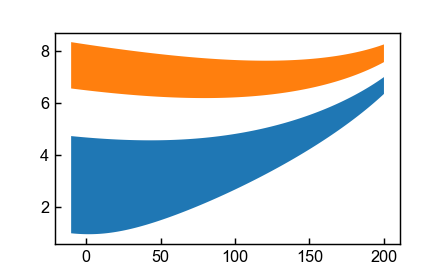

<IPython.core.display.Javascript object>


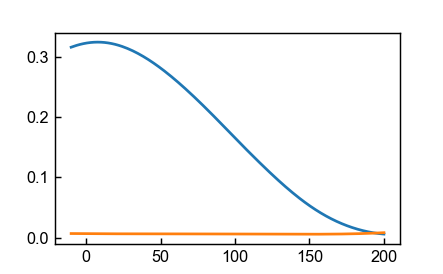

In [79]:
# ｌｏａｄ　ｄａｔａ：　ｌｏｗ　ａｎｇｌｅ　ａｎｄ　ａｌｓｏ　ｈｉｇｈ　ａｎｇｌｅ
# For SHO: use 5-25 and 35-45; factor=0.99,9.5
wch = [2,6] 
d_large = loaddat(fpath,fnames[wch[0]],loadpar) # low angle 6deg data of La,Sm2Zr2O7
d_small = loaddat(fpath,fnames[wch[1]],loadpar) # high angle 119deg data of Sm2Zr2O7

# low and high q limits for different energies within certain 2theta range
qs0 = np.vstack([clcq(241.45, d_large[:,0], two_th[wch[0],0]), 
                 clcq(241.45, d_large[:,0], two_th[wch[0],1])]).T
qs1 = np.vstack([clcq(241.45, d_small[:,0], two_th[wch[1],0]), 
                 clcq(241.45, d_small[:,0], two_th[wch[1],1])]).T
#print(qs0,qs1)
plt.figure()
#plt.plot(qs0,d_large[:,0],'r')
#plt.plot(qs1,d_large[:,0],'b')
plt.fill_between(d_large[:,0],qs0[:,0],qs0[:,1])
plt.fill_between(d_large[:,0],qs1[:,0],qs1[:,1])
plt.show()

#　load Sm3+ form facotor for intermultiplet transitions (k/4pi vs I)
smform = np.genfromtxt(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\Sm_formfactor_intermultiplet_transition.txt',skip_header=1)
smform[:,0]=smform[:,0]*4*np.pi
# make a interplation function
spl = interpolate.UnivariateSpline(smform[:,0], smform[:,1], s = 0.0001) # larger s more smooth

from scipy import integrate
ff_int0 = np.array([integrate.quad(spl, qs_lh[0], qs_lh[1])[0] for qs_lh in qs0])/(qs0[:,1]-qs0[:,0])
ff_int1 = np.array([integrate.quad(spl, qs_lh[0], qs_lh[1])[0] for qs_lh in qs1])/(qs1[:,1]-qs1[:,0])
#print(ff_int0,'\n',ff_int1)

plt.figure()
plt.plot(d_large[:,0],ff_int0)
plt.plot(d_small[:,0],ff_int1)

plt.show()

#d_large[:,1],d_large[:,2] = d_large[:,1]/(qs0[:,1]-qs0[:,0]), d_large[:,2]/(qs0[:,1]-qs0[:,0])
#d_small[:,1],d_small[:,2] = d_small[:,1]/(qs1[:,1]-qs1[:,0]), d_small[:,2]/(qs1[:,1]-qs1[:,0])

<IPython.core.display.Javascript object>


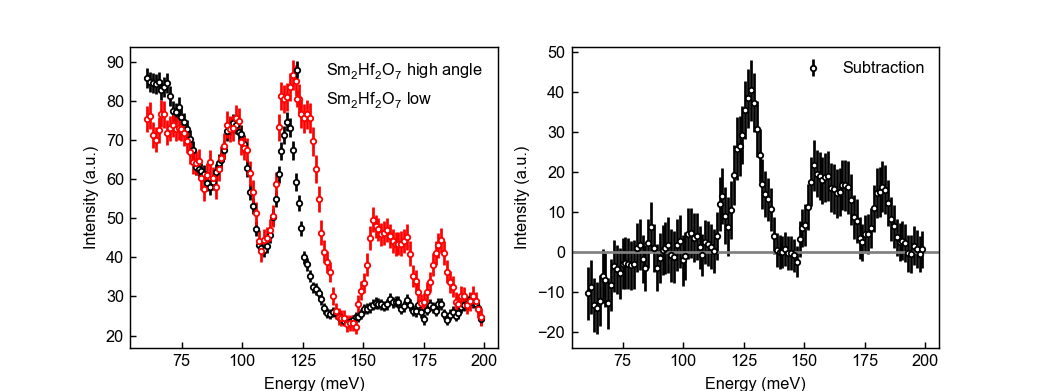

interactive(children=(FloatSlider(value=2.91, description='x1', max=10.0, step=0.01), FloatSlider(value=8.0, d…

<function __main__.pltSub(x1=0, x2=0)>

In [80]:
#　Check　Sm(2t:5-45)- a*Sm(2t:25-45)-b subtraction and plot
fig_label = (r'Sm$_2$Hf$_2$O$_7$ high angle', r'Sm$_2$Hf$_2$O$_7$ low','Subtraction')

# smooth the La data
#mask = (80< dat[:,0]) & (dat[:,0] <210) # change the fitting range
#yhat = savgol_filter(dat[mask,1], 21, 3) # window size , polynomial order 
#yinterp = interpolate.UnivariateSpline(dat[mask,0], dat[mask,1], s = 60)(dat[mask,0]) # larger s more smooth

factor=1; const=0

def pltSub(x1=0,x2=0):
    global fig, axs, factor, const
    axs[0].cla() 
    
    mask = (60< d_small[:,0]) & (d_small[:,0] <200)
    
    axs[0].errorbar(d_small[mask,0], x1*d_small[mask,1]+x2, yerr=x1*d_small[mask,2],ms=3,
                    mec='black', mfc='white',fmt='o',ecolor='black',label=fig_label[0])# plot a*La+b
    axs[0].errorbar(d_large[mask,0], d_large[mask,1], yerr= d_large[mask,2], ms=3,
                    mec='r', mfc='white',fmt='o',ecolor='r',label=fig_label[1])# plot Sm
    axs[0].legend(loc='best',numpoints=1,frameon=False)
    #axs[0].text(145,6,r'$2\theta=[8,10]$ deg',fontsize=14)
    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')#, zorder=0)#,xmin=80,xmax=220,)#,linewidth=0.5)
    axs[1].errorbar(d_large[mask,0], d_large[mask,1]-x1*d_small[mask,1]-x2, yerr=2*d_large[mask,2],ms=3.,
                    fmt='o', mec='black', mfc='white',ecolor='black', label=fig_label[2])
    axs[1].legend(loc='best',numpoints=1,frameon=False)
    
    #ax.set_yscale('log')
    axs[0].set_xlabel('Energy (meV)')
    axs[0].set_ylabel('Intensity (a.u.)')
    axs[1].set_xlabel('Energy (meV)')
    axs[1].set_ylabel('Intensity (a.u.)')

    #plt.suptitle('Sm- a*La-b for 9deg',fontsize=16)
    
    # Save just the portion _inside_ the first axis's boundaries
    # It's best to transform this back into figure coordinates. Otherwise, it won't behave correctly when the size of the plot is changed.
    #extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #extent1 = axs[0].xaxis.label.get_window_extent().transformed(fig.dpi_scale_trans.inverted())# not working
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches=extent+extent1+extent2,verbose=True)   
    #fig.savefig(os.path.join(fpath, r'nd_cp_crys_lowT.pdf'), bbox_inches=extent.expanded(1.3, 1.3),verbose=True)
    
    #extent = full_extent(axs[0], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(os.path.join(fpath, r'Sm_La.pdf'), bbox_inches=extent.expanded(1.02,1.02),verbose=True)
    #extent = full_extent(axs[1], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(os.path.join(fpath, r'Sm_La_sub.pdf'), bbox_inches=extent.expanded(1.02,1.02),verbose=True)
    factor=x1; const=x2
    return #fig

#fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(8,3))

interact(pltSub, x1=widgets.FloatSlider(min=0,max=10,step=0.01,value=1),
         x2=widgets.FloatSlider(min=-5,max=15,step=0.5,value=9))

<IPython.core.display.Javascript object>


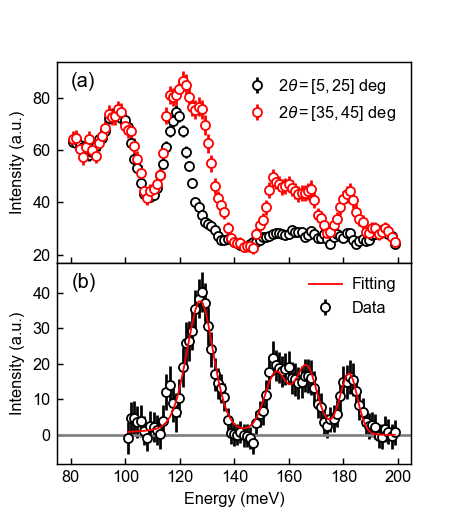

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [256]:
# Export the final figure: 
# !!!! you must have factor, const, final sub d_sub and fit !!!!
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False,figsize=[3.5,4])
fig.subplots_adjust(hspace=0)
mask = (80< d_small[:,0]) & (d_small[:,0] <200)
axs[0].errorbar(d_small[mask,0], factor*d_small[mask,1]+const, yerr=factor*d_small[mask,2],ms=5,
                    mec='black', mfc='white',fmt='o',ecolor='black',label=r'$2\theta=[5,25]$ deg')# plot a*La+b
axs[0].errorbar(d_large[mask,0], d_large[mask,1], yerr= d_large[mask,2], ms=5,
                mec='r', mfc='white',fmt='o',ecolor='r',label=r'$2\theta=[35,45]$ deg')# plot Sm
axs[0].legend(loc='best',numpoints=1,frameon=False)

axs[1].errorbar(d_sub[:,0], d_sub[:,1], d_sub[:,2], marker='o', ms=5, fmt='o',mfc='white',mec='black',ecolor='black',label='Data')
axs[1].plot(d_sub[:,0], result.best_fit, 'r-', lw=1, alpha=1, label='Fitting',zorder=10) 
axs[1].axhline(y=0.0, c='grey')
#ax.set_xlim([80,210])
#ax.set_ylim([-2,8])

#axs[1].set_xlabel('Energy (meV)')
axs[0].set_ylabel('Intensity (a.u.)')
axs[0].legend(frameon=False, numpoints=1,handletextpad=0.3)

axs[1].set_xlabel('Energy (meV)')
axs[1].set_ylabel('Intensity (a.u.)')
axs[1].legend(frameon=False, numpoints=1,handletextpad=0.6)

axs[0].text(0.04, 0.9, '(a)', size=11, color='black', ha='left', va='center',transform=axs[0].transAxes,
            backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))   
axs[1].text(0.075, 0.9, '(b)', size=11, color='black', ha='center', va='center',transform=axs[1].transAxes,
            backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))

fig.savefig(os.path.join(fpath, r'Sm_high_low_sub.pdf'), bbox_inches="tight",pad_inches=0.01,verbose=True)
plt.show()

<IPython.core.display.Javascript object>


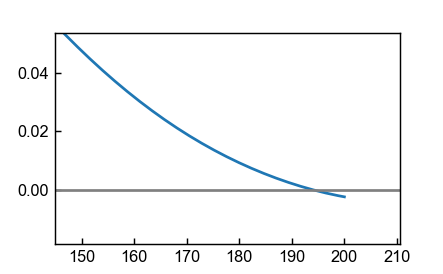

In [81]:
# Check the correction factor: negative factors!!!
plt.figure()
plt.plot(d_large[:,0],ff_int0-ff_int1*factor)
plt.axhline(y=0.0, c='grey')
plt.show()

In [94]:
print(1/d_sub[:,2])

[0.03148685 0.03149388 0.03120446 0.02785799 0.02394278 0.02250626
 0.02170417 0.02070365 0.02065043 0.01905372 0.01787488 0.01837702
 0.01838247 0.01779185 0.01717469 0.01628185 0.01611309 0.01631882
 0.01664161 0.01724074 0.01807498 0.01866837 0.01864068 0.02065361
 0.0219051  0.02096327 0.02104562 0.0198153  0.01874067 0.01800944
 0.01778145 0.01801772 0.01496413 0.01365283 0.01195264 0.01037134
 0.00931813 0.00860356 0.00878072 0.00831246 0.0080251  0.00738029
 0.006779   0.00662636 0.00614664 0.00592456 0.00565576 0.00508533
 0.00473594 0.00426236 0.00413234 0.00449571 0.00420743 0.00413486
 0.00424075 0.00384804 0.00334858 0.00301571 0.00238236 0.0020219
 0.00179121 0.00155234 0.00142067 0.00131592 0.00117136 0.00101006
 0.00093157 0.00071896]


1.0 9.0
[[Model]]
    Model(four_pv)
[[Fit Statistics]]
    # function evals   = 319
    # data points      = 68
    # variables        = 15
    chi-square         = 1856.578
    reduced chi-square = 35.030
    Akaike info crit   = 254.875
    Bayesian info crit = 288.167
[[Variables]]
    A1:        4544.44922 +/- 841.6720 (18.52%) (init= 4500)
    ratio1:    0.40577986 +/- 0.295732 (72.88%) (init= 0.5)
    mu1:       127.700004 +/- 0.238659 (0.19%) (init= 128)
    sigma1:    3.59563074 +/- 0.189593 (5.27%)  == 'gamma1/(2*log2(2))**0.5'
    gamma1:    5.08498976 +/- 0.268125 (5.27%) (init= 5)
    A2:        4069.99569 +/- 788.9591 (19.38%) (init= 3800)
    ratio2:    5.0427e-09 +/- 0.420896 (8346721359.59%) (init= 0.5)
    mu2:       156.846973 +/- 0.696099 (0.44%) (init= 155)
    sigma2:    2.88931931 +/- 0.345337 (11.95%)  == 'gamma2/(2*log2(2))**0.5'
    gamma2:    4.08611456 +/- 0.488380 (11.95%) (init= 4)
    A20:       4715.28103 +/- 1.94e+03 (41.04%) (init= 5000)
    ratio20:  

<IPython.core.display.Javascript object>


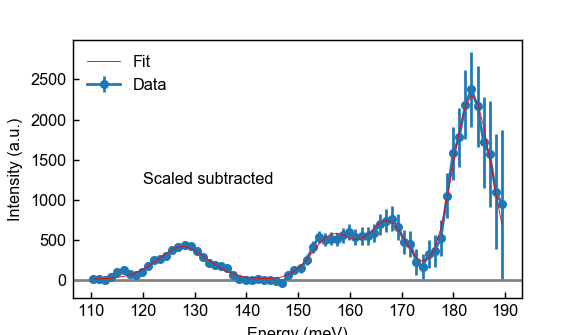

In [115]:
# Fit peak position and intensity based on the subtractd data
# with PV function ｗｉｔｈｏｕｔ　ｃｏｎｓｉｄｅｒｉｎｇ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
# a cell below do the fitting ｗｉｔｈ　ｃｏｎｓｉｄｅｒｉｎｇ　ｔｈｅ　ｆｏｒｍ　ｆａｃｔｏｒ
def pv_func(x,A,ratio,mu,sigma,gamma):
    return A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
              ratio/np.pi*gamma/((x-mu)**2+gamma**2))
    
def three_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1)+pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+pv_func(x,A3,ratio3,mu3,sigma3,gamma3)

def four_pv(x,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    return pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3)

print(factor,const)

## No formfactor correction
# d_sub = np.vstack([d_large[:,0], d_large[:,1]-factor*d_small[:,1]-const, d_large[:,2]]).T

## Do the formfactor correction: "/(ff_int0-ff_int1*factor)"
d_sub = np.vstack([d_large[:,0], 
                   (d_large[:,1]-factor*d_small[:,1]-const)/(ff_int0- factor*ff_int1), 
                    1.*d_large[:,2]/(ff_int0- factor*ff_int1)]).T

## Assumming the high angle region has no mag intensity: "/ff_int0"
# d_sub = np.vstack([d_large[:,0], 
#                    (d_large[:,1]-factor*d_small[:,1]-const)/ff_int0,
#                    d_large[:,2]]).T

mask = (110< d_sub[:,0]) & (d_sub[:,0] <190)
d_sub = d_sub[mask,:]

#pvmod=Model(three_pv)
pvmod=Model(four_pv)

params = pvmod.make_params()
#print pvmod.param_names
#print pvmod.independent_vars

params['A1'].set(value=4500., vary=True, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1)
params['mu1'].set(value=128, vary=True, min=None, max=None)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='gamma1/(2*log2(2))**0.5')
params['gamma1'].set(value=5, vary=True, min=None, max=None)

params['A2'].set(value=3800, vary=True, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=155., vary=True, min=145, max=160)
params['sigma2'].set(value=None, vary=False, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=4, vary=True, min=None, max=None)

# fit with four pv_functions and constrian the overlapping peak to have the same width
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=5000, vary=True, min=0, max=None)
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=170., vary=True, min=160, max=175)
params['sigma20'].set(value=None, vary=False, min=None, max=None, expr='gamma20/(2*log2(2))**0.5')
params['gamma20'].set(value=3, vary=True, min=0, max=None)#,expr='gamma2')

params['A3'].set(value=15000., vary=True, min=0, max=None)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=183, vary=True, min=175, max=185)
params['sigma3'].set(value=None, vary=False, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=3, vary=True, min=0, max=None)

#print params.valuesdict()

result = pvmod.fit(d_sub[:,1], x=d_sub[:,0], params = params, weights=1/np.sqrt(np.abs(d_sub[:,2])))# only with sqrt works
print(result.fit_report(modelpars=None, show_correl=False))
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots()
ax.errorbar(d_sub[:,0], d_sub[:,1], d_sub[:,2],marker='o', ms=4,label='Data',)
ax.plot(d_sub[:,0], result.best_fit, 'r-', lw=0.5, alpha=1, label='Fit',zorder=10) 
ax.axhline(y=0.0, c='grey')
#ax.set_ylim([-2,8])
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Intensity (a.u.)')
ax.text(120,1200,'Scaled subtracted')
plt.legend(frameon=False, numpoints=1)
plt.show()


In [116]:
### Show the center and area ratio
print([result.params['mu'+i].value for i in ['1','2','20','3']])
print(np.array([result.params['A'+i].value for i in ['1','2','20','3']])
      /result.params['A3'].value)

## Calculate ratio with errorbars
# use simpler
area, mu = [], []
for idx, key in enumerate(params.keys()):
    if 'A' in key:
        area.append(unc.ufloat(result.params[key].value, result.params[key].stderr))
    elif 'mu' in key:
        mu.append(unc.ufloat(result.params[key].value,result.params[key].stderr))

area = np.array(area)
mu = np.array(mu)        
print(area,'\n',mu)
print(area/area[-1])

# calculated manually
a, aerr = 4561, -1597
b, berr = 15482, -2731
print(np.sqrt(b**(-2)*aerr**2 + a**2/b**4*berr))

[127.70000398493848, 156.84697375833773, 167.36023164765646, 183.59256134621657]
[0.29879546 0.26760035 0.31002757 1.        ]
[4544.449225058274+/-841.6720686195353
 4069.995690120013+/-788.959137641247
 4715.281031729244+/-1935.1090499470617
 15209.231301681742+/-4624.215240202231] 
 [127.70000398493848+/-0.23865990089473738
 156.84697375833773+/-0.6960999811320095
 167.36023164765646+/-0.4640095658278096
 183.59256134621657+/-0.13810302392313037]
[0.29879545750321895+/-0.10637397354951694
 0.2676003546392235+/-0.09649108443568435
 0.3100275706378308+/-0.15834524041419828 1.0+/-0]
0.10314725422558074


In [457]:
np.array([0.49,0.37,0.72,1.63])/1.63

array([0.3006135 , 0.22699387, 0.44171779, 1.        ])

[[Model]]
    Model(four_pv_scale)
[[Fit Statistics]]
    # function evals   = 60
    # data points      = 84
    # variables        = 7
    chi-square         = 562.400
    reduced chi-square = 7.304
    Akaike info crit   = 173.717
    Bayesian info crit = 190.733
[[Variables]]
    scale:     15411.2790 +/- 900.2734 (5.84%) (init= 16420)
    A1:        0.29 (fixed)
    ratio1:    0.39347490 +/- 0.126692 (32.20%) (init= 0.5)
    mu1:       128 (fixed)
    sigma1:    3.62809521 +/- 0.154024 (4.25%)  == 'gamma1/(2*log2(2))**0.5'
    gamma1:    5.13090145 +/- 0.217823 (4.25%) (init= 5)
    A2:        0.23 (fixed)
    ratio2:    0.23229125 +/- 0.157980 (68.01%) (init= 0.5)
    mu2:       155.79 (fixed)
    sigma2:    2.91903103 +/- 0.187775 (6.43%)  == 'gamma2/(2*log2(2))**0.5'
    gamma2:    4.12813327 +/- 0.265555 (6.43%) (init= 4)
    A20:       0.44 (fixed)
    ratio20:   0.23229125 +/- 0.157980 (68.01%)  == 'ratio2'
    mu20:      167.18 (fixed)
    sigma20:   2.91903103 +/- 0       

<IPython.core.display.Javascript object>


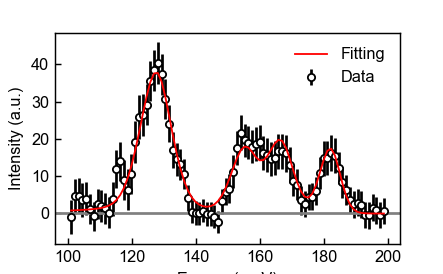

In [121]:
# Ｆｉｔ　ｐｅａｋ　ｗｉｄｔｈｓ　ｗｉｔｈ　ｆｉｘｉｎｇ　ｐｏｓ　ａｎｄ　ａｒｅａ　ｔｏ　ｂｅ　ｔｈｅ　ＣＥＦ　ｆｉｔｔｅｄ　ｖａｌｕｅｓ
# def pv_func(x,A,ratio,mu,sigma,gamma):
#     global factor, wch, two_th
#     ff_int0 = ff_int(x, two_th[wch[0],0], two_th[wch[0],1], ei=241.45)
#     ff_int1 = ff_int(x, two_th[wch[1],0], two_th[wch[1],1], ei=241.45)
#     return (ff_int0-factor*ff_int1)* A*((1-ratio)/(sigma*(2*np.pi)**0.5)*np.exp(-(x-mu)**2/(2*sigma)**2) + \
#               ratio/np.pi*gamma/((x-mu)**2+gamma**2))

def four_pv_scale(x,scale,A1,ratio1,mu1,sigma1,gamma1,A2,ratio2,mu2,sigma2,gamma2,
                  A20,ratio20,mu20,sigma20,gamma20, A3,ratio3,mu3,sigma3,gamma3):
    global factor, wch, two_th
    ff_int0 = ff_int(x, two_th[wch[0],0], two_th[wch[0],1], ei=241.45)
    ff_int1 = ff_int(x, two_th[wch[1],0], two_th[wch[1],1], ei=241.45)
    return scale*(ff_int0-factor*ff_int1) *  ( pv_func(x,A1,ratio1,mu1,sigma1,gamma1) + pv_func(x,A2,ratio2,mu2,sigma2,gamma2)+ \
           pv_func(x,A20,ratio20,mu20,sigma20,gamma20) + pv_func(x,A3,ratio3,mu3,sigma3,gamma3 ) )

d_sub = np.vstack([d_large[:,0], 
                  (d_large[:,1]-factor*d_small[:,1]-const), 
                   1.5*d_large[:,2]]).T

mask = (100< d_sub[:,0]) & (d_sub[:,0] <200)
d_sub = d_sub[mask,:]

pvmod=Model(four_pv_scale)
params = pvmod.make_params()

cefmu = [128, 155.79, 167.18, 183.04]

#ff_int00 = ff_int(cefmu, two_th[wch[0],0], two_th[wch[0],1], ei=241.45)
#ff_int11 = ff_int(cefmu, two_th[wch[1],0], two_th[wch[1],1], ei=241.45)
cefa = np.array([0.29,0.23,0.44,1])#*(ff_int00-factor*ff_int11)

params['scale'].set(value=16420, vary=True, min=0, max=None)

params['A1'].set(value=cefa[0], vary=False, min=0, max=None)
params['ratio1'].set(value=0.5, vary=True, min=0, max=1)
params['mu1'].set(value=cefmu[0], vary=False, min=None, max=None)
params['sigma1'].set(value=None, vary=False, min=None, max=None, expr='gamma1/(2*log2(2))**0.5')
params['gamma1'].set(value=5, vary=True, min=0, max=6)

params['A2'].set(value=cefa[1], vary=False, min=0, max=None)
params['ratio2'].set(value=0.5, vary=True, min=0, max=1)
params['mu2'].set(value=cefmu[1], vary=False, min=None, max=None)
params['sigma2'].set(value=None, vary=True, min=None, max=None, expr='gamma2/(2*log2(2))**0.5')
params['gamma2'].set(value=4, vary=True, min=0, max=6)

# fit with four pv_functions and constrian the overlapping peak to have the same area
# comment out the five pars bellow if use three_pv for fitting
params['A20'].set(value=cefa[2], vary=False, min=0, max=None)
params['ratio20'].set(value=None, vary=False, min=0, max=1,expr='ratio2')
params['mu20'].set(value=cefmu[2], vary=False, min=None, max=None)
params['sigma20'].set(value=None, vary=True, min=None, max=None, expr='sigma2')
params['gamma20'].set(value=4, vary=True, min=0, max=6,expr='gamma2')

params['A3'].set(value=cefa[3], vary=False, min=0, max=None)
params['ratio3'].set(value=0.5, vary=True, min=0, max=1)
params['mu3'].set(value=cefmu[3], vary=False, min=None, max=None)
params['sigma3'].set(value=None, vary=True, min=None, max=None, expr='gamma3/(2*log2(2))**0.5')
params['gamma3'].set(value=5, vary=True, min=0, max=6)

#print params.valuesdict()

#fit
result = pvmod.fit(d_sub[:,1], x=d_sub[:,0], params = params)

print(result.fit_report(modelpars=None, show_correl=False))
#print 'fitted:','\n', result.params.valuesdict()

fig, ax = plt.subplots()
ax.errorbar(d_sub[:,0], d_sub[:,1], d_sub[:,2], marker='o', ms=4, fmt='o',mfc='white',mec='black',ecolor='black',label='Data')
ax.plot(d_sub[:,0], result.best_fit, 'r-', lw=1, alpha=1, label='Fitting',zorder=10) 
ax.axhline(y=0.0, c='grey')
#ax.set_xlim([80,210])
#ax.set_ylim([-2,8])
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Intensity (a.u.)')
plt.legend(frameon=False, numpoints=1)
#fig.savefig(os.path.join(fpath, r'Sm_cef_fit.pdf'), bbox_inches='tight',verbose=True)
plt.show()


## Formfactor of Sm$^{3+}$ for intermultiplet transition

In [249]:
# ｌｏａｄ　ｄａｔａ：　
#Data I-Q for La,Sm2Zr2O7 at 128.5meV
fnames = ['MER31902_Ei235.00meV_Rings_cut(127,129).txt',
          'MER31902_Ei235.00meV_Rings_cut(107,109).txt',
          'MER31902_Ei235.00meV_Rings_cut(144,146).txt',
          'MER31930_Ei235.00meV_Rings_cut(127,129).txt']

loadpar = dict(skip_header=1, usecols=(0,1,2))
dat_sm0 = loaddat(fpath,fnames[0],loadpar) 
dat_sm1 = loaddat(fpath,fnames[1],loadpar) 
dat_la0 = loaddat(fpath,fnames[2],loadpar) 

start = np.max([dat_sm0[0,0], dat_sm1[0,0]] )
end   = np.min([dat_sm0[-1,0],dat_sm1[-1,0]])

# the thory I=Q data for Sm form factor
smform = np.genfromtxt(r'D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\Sm_formfactor_intermultiplet_transition.txt',skip_header=1)
#print smform
# nbins = 80
# dat_sm0 = lin_binning(dat_sm0[:,0], dat_sm0[:,1], nbins)
# dat_sm1 = lin_binning(dat_sm1[:,0], dat_sm1[:,1], nbins)
# dat_la0 = lin_binning(dat_la0[:,0], dat_la0[:,1], nbins)
#dat = np.vstack([dla,dnd]).T

D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31902_Ei235.00meV_Rings_cut(127,129).txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31902_Ei235.00meV_Rings_cut(107,109).txt
D:\5_Neutron Scattering\7_Merlin_Mar_2016_SmZrO\SmHfO_analysis/MER31902_Ei235.00meV_Rings_cut(144,146).txt


In [221]:
print(dat_sm0.shape,dat_sm1.shape)

(60, 3) (60, 3)


In [226]:
# Subtraction: two patterns and only retrun the common region
def subtract(arr0,arr1,factor=1,cal_e=False): #input: arr0 n-by-3 (data), arr1 (bkg)
    '''
    # Test subtract
    arr1 = np.array([[2,1,0],[3,2,0]])
    arr2 = np.array([[0,1,0],[1,2,0]])
    subtract(arr1,arr2)
    '''
    from scipy.interpolate import interp1d
    
    Min = np.max([arr0[:,0].min(),arr1[:,0].min()])
    Max = np.min([arr0[:,0].max(),arr1[:,0].max()])
    #print(Min,Max)
    if Min>=Max:
        raise RuntimeError('no common ranage for the inputs')
    arr0 = arr0[ (Min<=arr0[:,0]) & (arr0[:,0]<=Max), :]
    arr1 = arr1[ (Min<=arr1[:,0]) & (arr1[:,0]<=Max), :]
    
    if len(arr0)<len(arr1):
        f = interp1d(arr1[:,0],arr1[:,1])
        arr0[:,1] = arr0[:,1] - factor*f(arr0[:,0])
        if cal_e:
            f = interp1d(arr1[:,0],arr1[:,2])
            arr0[:,2] = arr0[:,2] + factor*f(arr0[:,0])
        return arr0
    else:
        f = interp1d(arr0[:,0], arr0[:,1])
        arr1[:,1] = f(arr1[:,0]) - factor*arr1[:,1]
        if cal_e:
            f = interp1d(arr0[:,0],arr0[:,2])
            arr1[:,2] = f(arr1[:,0]) + factor*arr1[:,2]   
        return arr1

subtract(dat_sm0, dat_sm1, factor=1, cal_e=False)

array([[ 3.67924528e+00,  2.88569611e+00,  3.44289661e-01],
       [ 3.91509434e+00,  3.07289522e+00,  8.43426090e-02],
       [ 4.10377358e+00,  2.61710957e+00,  1.49266553e-01],
       [ 4.29245283e+00,  1.95468017e+00,  1.50598816e-01],
       [ 4.52830189e+00, -3.99530072e-02,  1.54585378e-01],
       [ 4.76415094e+00,  2.03870173e-01,  1.09294785e-01],
       [ 4.95283019e+00, -1.95437941e-02,  1.77351621e-01],
       [ 5.14150943e+00, -5.60680589e-01,  1.67856088e-01],
       [ 5.33018868e+00,  5.90441215e-01,  1.23577479e-01],
       [ 5.56603774e+00, -7.50287503e-01,  7.11767098e-02],
       [ 5.80188679e+00, -3.98351026e-01,  6.68279162e-02],
       [ 5.99056604e+00, -8.54459497e-01,  1.25888449e-01],
       [ 6.17924528e+00,  7.94440985e-02,  1.42658441e-04],
       [ 6.41509434e+00, -1.02059288e+00,  2.61954772e-01],
       [ 6.65094340e+00, -1.63093646e+00,  8.39791929e-02],
       [ 6.83962264e+00, -1.57594370e+00,  6.35492032e-02],
       [ 7.02830189e+00, -4.22032181e-01

<IPython.core.display.Javascript object>


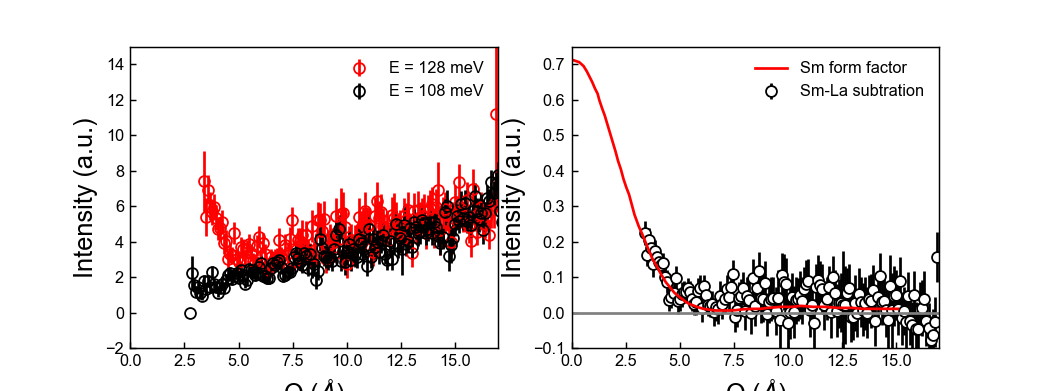

interactive(children=(FloatSlider(value=0.59, description='x1', max=0.7, step=0.001), FloatSlider(value=0.0, d…

<function __main__.pltSub(x1, x2, x3, x4)>

In [260]:
%matplotlib notebook
# # form factor at 128meV　: Sm- a*La-b subtraction and plot
fig_label = (r'La$_2$Zr$_2$O$_7$', r'Sm$_2$Zr$_2$O$_7$','Subtraction')
fig_label = (r'E = 108 meV', r'E = 128 meV','Subtraction')
# Two methods: try to smooth La data
#yhat = savgol_filter(dat[:,1], 71, 0) # window size , polynomial order 
#yinterp = interpolate.UnivariateSpline(dat[:,0], dat[:,1], s = 5e8)(dat[:,0]) # larger s more smooth

def pltSub(x1,x2,x3,x4):# x1 and x2 for subtration, x3 and x4 for matching theory to data
    global fig, axs
    axs[0].cla()  
    
    axs[0].errorbar(dat_sm0[:,0], dat_sm0[:,1], yerr= dat_sm0[:,2], fmt='o',mfc='none',mec='r',ecolor='r',label=fig_label[1])# plot Sm
    axs[0].errorbar(dat_sm1[:,0], x1*dat_sm1[:,1]+x2, yerr=x1*dat_sm1[:,2],
                    fmt='o',mfc='none',mec='black',ecolor='black',label=fig_label[0])# plot a*La+b
    #axs[0].plot(dat[:,0], x1*yhat+x2, color='r', label='Scaled fitted La') # fitted La
    #axs[0].plot(dat[:,0], x1*yinterp+x2, label = 'Interpolated')
    #axs[0].plot(dat[:,3], dat[:,4]-x1*dat[:,1]-x2, label=fig_label[2]) # plot subtraction
    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')#, zorder=0)#,xmin=80,xmax=220,)#,linewidth=0.5)
    #axs[1].errorbar(dat[:,3], dat[:,4]-x1*dat[:,1]-x2, yerr=dat[:,5],fmt='o', label=fig_label[2])
    sub = subtract(dat_sm0, dat_sm1, factor=x1, cal_e=False)-x2
    axs[1].errorbar(sub[:,0], x3*sub[:,1]+x4, yerr=x3*1.5*sub[:,2],fmt='o',mfc='white',mec='black',ecolor='black', label='Sm-La subtration',zorder=1)
    
    axs[1].plot(smform[:,0]*4*np.pi, smform[:,1],'r-',label='Sm form factor')
    axs[0].set_xlim(0, 17)
    axs[0].set_ylim(-2, 15)
    axs[0].legend(loc='best',frameon=False, numpoints=1)
    axs[0].set_xlabel('Q ($\AA$)',fontsize=14)
    axs[0].set_ylabel('Intensity (a.u.)',fontsize=14)
    
    axs[1].set_xlim(0, 17)
    axs[1].set_ylim(-0.1, 0.75)
    axs[1].legend(loc='best',frameon=False, numpoints=1)
    axs[1].set_xlabel('Q ($\AA$)',fontsize=14)
    axs[1].set_ylabel('Intensity (a.u.)',fontsize=14)
    # Fialed: try to remove the blank left end in the save first subplot:if set subplots have thems xlim, fine
    #fig.tight_layout()# remove the left blank of subplot 1
    #plt.subplots_adjust(left=0.1)#, bottom=0.1, right=1.1, top=1.1, wspace=0.1, hspace=0)
    #plt.suptitle('Sm- a*La-b (FormFactor @ 128meV)')
    
    #fig.delaxes(axs[1])
    #extent = full_extent(axs[0], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(os.path.join(fpath, r'Sm_La_form.pdf'), bbox_inches=extent.expanded(1.02,1.02))
    #extent = full_extent(axs[1], pad=0.0).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(os.path.join(fpath, r'Sm_La_form_sub.pdf'), bbox_inches=extent.expanded(1.02,1.02),verbose=True) 

    return# fig

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(8, 3),
                        gridspec_kw = {'width_ratios':[1, 1]})

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.59),
                 x2=widgets.FloatSlider(min=-5,max=5,step=0.1,value=0),
                 x3=widgets.FloatSlider(min=0,max=0.05,step=0.001,value=0.04),
                 x4=widgets.FloatSlider(min=-0.02,max=0.02,step=0.001,value=0)) #old x1=0.55,x4=-0.008

<IPython.core.display.Javascript object>


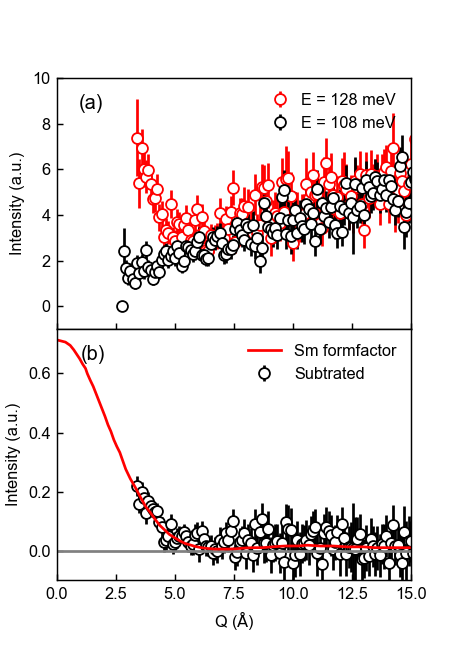

interactive(children=(FloatSlider(value=0.64, description='x1', max=0.7, step=0.001), FloatSlider(value=0.0, d…

<function __main__.pltSub(x1, x2, x3, x4)>

In [261]:
# Export the final figure
def pltSub(x1,x2,x3,x4):# x1 and x2 for subtration, x3 and x4 for matching theory to data
    global fig, axs
    axs[0].cla()  
    
    axs[0].errorbar(dat_sm0[:,0], dat_sm0[:,1], yerr= dat_sm0[:,2], 
                    fmt='o',mfc='w',mec='r',ecolor='r',label=fig_label[1])# plot Sm
    axs[0].errorbar(dat_sm1[:,0], x1*dat_sm1[:,1]+x2, yerr=x1*dat_sm1[:,2],
                    fmt='o',mfc='w',mec='black',ecolor='black',label=fig_label[0])# plot a*La+b    
    axs[1].cla() 
    axs[1].axhline(y=0.0, c='grey')#, zorder=0)#,xmin=80,xmax=220,)#,linewidth=0.5)
    
    sub = subtract(dat_sm0, dat_sm1, factor=x1, cal_e=False)-x2
    axs[1].errorbar(sub[:,0], x3*sub[:,1]+x4, yerr=x3*1.5*sub[:,2],
                    fmt='o',mfc='white',mec='black',ecolor='black', label='Subtrated',zorder=1)
    
    axs[1].plot(smform[:,0]*4*np.pi, smform[:,1],'r-',label='Sm formfactor')
    
    axs[0].set_ylim(-1, 10)
    axs[0].legend(loc='best',frameon=False, numpoints=1,handletextpad=0.3)
    axs[0].set_ylabel('Intensity (a.u.)')
    
    axs[1].set_xlim(0, 15)
    axs[1].set_ylim(-0.1, 0.75)
    axs[1].legend(loc='best',frameon=False, numpoints=1)
    axs[1].set_xlabel('Q ($\mathsf{\AA}$)')
    axs[1].set_ylabel('Intensity (a.u.)') 

    axs[0].text(0.06, 0.9, '(a)', size=11, color='black', ha='left', va='center',transform=axs[0].transAxes,
            backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))   
    axs[1].text(0.1, 0.9, '(b)', size=11, color='black', ha='center', va='center',transform=axs[1].transAxes,
            backgroundcolor='white',bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))
    fig.savefig(os.path.join(fpath, r'Sm_formfact_sub.pdf'), bbox_inches="tight",pad_inches=0.01,verbose=True)

    return# fig

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False,figsize=[3.5,5])
fig.subplots_adjust(hspace=0)

interact(pltSub, x1=widgets.FloatSlider(min=0,max=0.7,step=0.001,value=0.64),
                 x2=widgets.FloatSlider(min=-5,max=5,step=0.1,value=0.),
                 x3=widgets.FloatSlider(min=0,max=0.05,step=0.001,value=0.04),
                 x4=widgets.FloatSlider(min=-0.02,max=0.02,step=0.001,value=0)) #old x1=0.55,x4=-0.008
